# ID Card prediction test

This notebook demonstrates a test with 4 example ID Cards. The previously trained model "model.h5" is loaded and a prediction is made. The prediction is a mask of the ID Card on the picture. Then a corner detection and 4 point transformation is performed on the mask to get a frontal view of the ID Card.

In [1]:
import tensorflow as tf
os.environ["SM_FRAMEWORK"] = "tf.keras"

import numpy as np
import skimage.io as io
import random
import os,sys
import glob
import cv2
import json
import pydash as pyd

from pycocotools.coco import COCO

from utils.pycoco import *
from utils.augmentation import *
from utils.data_loader import Dataset, Dataloader
from utils.image_util import *

import segmentation_models as sm

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import time
%matplotlib inline

Segmentation Models: using `tf.keras` framework.
Using TensorFlow backend.


In [2]:
IMPORT_FILES = "./images/*"
MODEL_FILE = "./model/model.h5"

#### Helper functions

In [3]:
def load_image(file_path, preprocessing):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width = img.shape[:2]
    img = cv2.resize(img, (320, 320), interpolation=cv2.INTER_AREA)

    sample = preprocessing(image=img)
    return sample['image'], height, width

def predict_image(model, image, width, height):
    image = np.expand_dims(image, axis=0)
    mask = model.predict(image)

    mask = cv2.resize(mask.squeeze(), (width, height), interpolation=cv2.INTER_AREA)
    mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1]

    return mask

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

### Preprocessing

Load sample .png images from ./test/ folder and create a dictionary with the raw image and the required data for prediction.

In [5]:
BACKBONE = 'efficientnetb3'

classes = ['person']
n_classes = 1 if len(classes) == 1 else (len(classes) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
R = 0.0001

In [6]:
images_dict = []
for file_path in glob.glob(IMPORT_FILES):
    raw = cv2.imread(file_path)
    img, h, w = load_image(file_path, get_preprocessing(sm.get_preprocessing(BACKBONE)))
    
    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    images_dict.append({"raw": raw, "data": img, "height": h, "width": w})        

In [7]:
gs = gridspec.GridSpec(1, len(images_dict))

Show sample images.

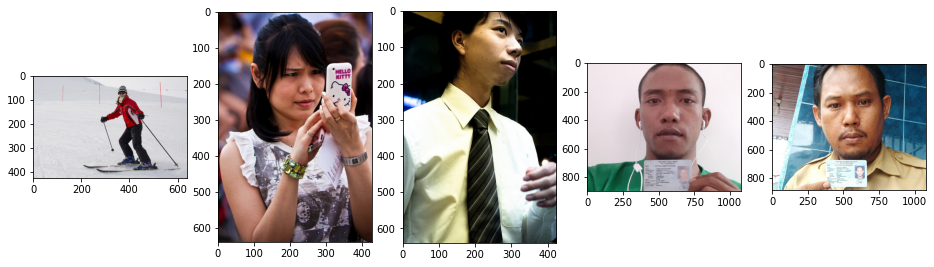

In [8]:
fig = plt.figure(figsize=(16, 6))
for n in range(len(images_dict)):
    ax = fig.add_subplot(gs[n])
    ax.imshow(images_dict[n]["raw"])

### Prediction
##### Load the Model

In [9]:
#create model
model = sm.Unet(BACKBONE,classes=n_classes, activation=activation)

model.load_weights(MODEL_FILE)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Execute prediction for all sample images and store the predicted mask in the dictionary.

In [10]:
for n in range(len(images_dict)):
    start_time = time.time()

    images_dict[n]["predicted_mask"] = predict_image(model, images_dict[n]["data"], images_dict[n]["width"], images_dict[n]["height"])
    print('inference time:', time.time()-start_time)

inference time: 4.945817232131958
inference time: 0.06403446197509766
inference time: 0.061002492904663086
inference time: 0.0630030632019043
inference time: 0.06761860847473145


Show predicted images.

# Result

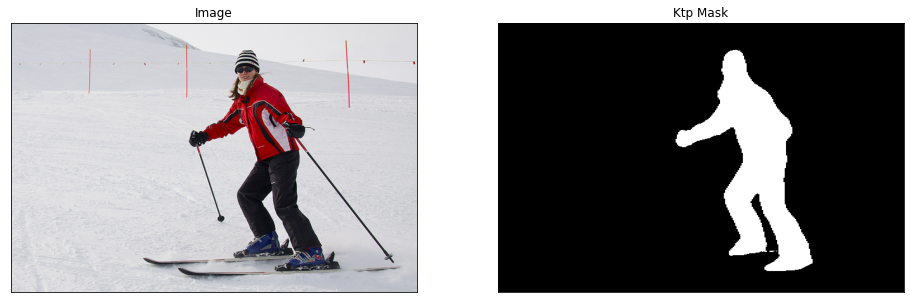

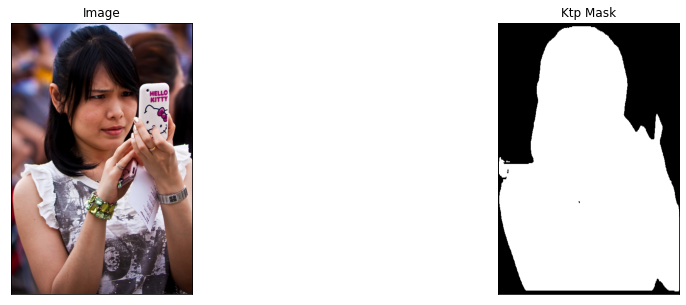

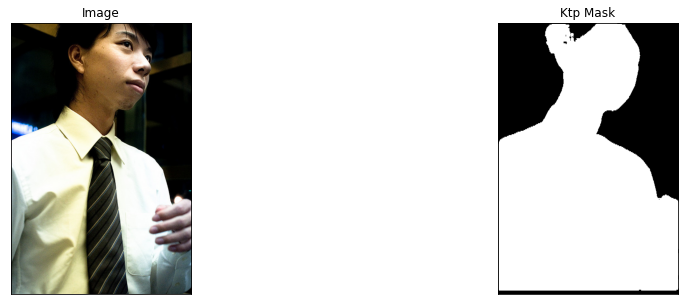

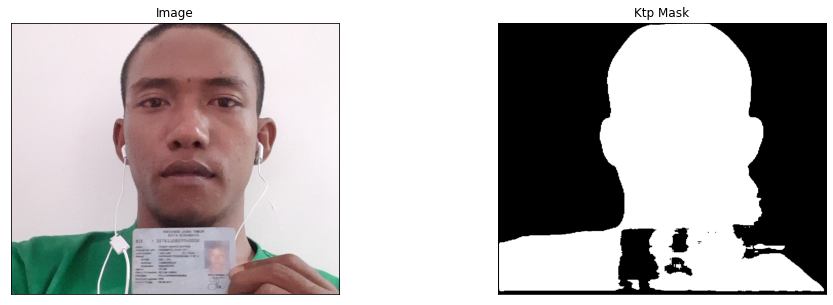

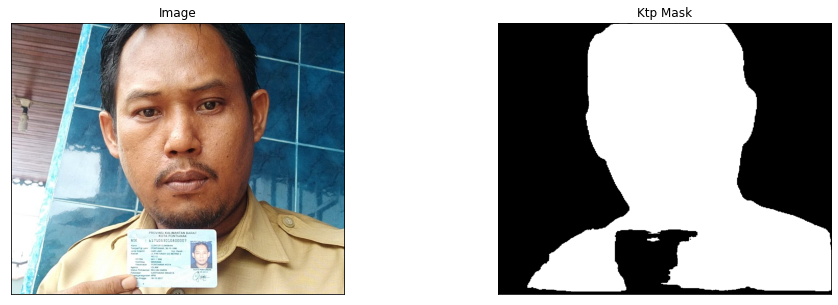

In [11]:
for n in range(len(images_dict)):
    image = images_dict[n]["raw"]
    mask = images_dict[n]["predicted_mask"]

    visualize(
        image=image,
        ktp_mask=mask
    )  